In [ ]:
# تثبيت المكتبات اللازمة
!pip install rdkit pandas requests

In [1]:
import requests # لسحب البيانات من الإنترنت
import pandas as pd # لتنظيم البيانات في جداول
from rdkit import Chem # للتعامل مع الجزيئات الكيميائية
from rdkit.Chem import Descriptors # لحساب الخصائص الفيزيوكيميائية

In [2]:
import requests
import pandas as pd

# قائمة بـ 10 مركبات عضوية متنوعة لمشروعك
organic_compounds = [
    "Aspirin", "Caffeine", "Paracetamol", "Ibuprofen", 
    "Benzene", "Ethanol", "Menthol", "Nicotine", 
    "Penicillin G", "Cholesterol"
]

results = []

for name in organic_compounds:
    # عدلنا الرابط هنا ليطلب الـ SMILES بشكل مباشر ومضمون
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/MolecularWeight,SMILES/JSON"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        props = data['PropertyTable']['Properties'][0]
        results.append({
            "Name": name,
            "SMILES": props.get('SMILES'),
            "MW": props.get('MolecularWeight')
        })

# عرض الجدول النهائي
df_compounds = pd.DataFrame(results)
df_compounds

,Name,SMILES,MW
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,180.16
1,Caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,194.19
2,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,151.16
3,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,206.28
4,Benzene,C1=CC=CC=C1,78.11
5,Ethanol,CCO,46.07
6,Menthol,CC1CCC(C(C1)O)C(C)C,156.26
7,Nicotine,CN1CCC[C@H]1C2=CN=CC=C2,162.23
8,Penicillin G,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...,334.4
9,Cholesterol,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,386.7


In [3]:
# دالة لحساب الخصائص الكيميائية
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            "LogP": Descriptors.MolLogP(mol), # معامل التقسيم (الذوبانية في الدهون)
            "H_Donors": Descriptors.NumHDonors(mol), # عدد الروابط المانحة للهيدروجين
            "H_Acceptors": Descriptors.NumHAcceptors(mol), # عدد الروابط المستقبلة للهيدروجين
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol) # الروابط القابلة للدوران
        }
    else:
        return None

# تطبيق الدالة على الجدول
descriptors_list = df_compounds['SMILES'].apply(calculate_descriptors).tolist()
df_descriptors = pd.DataFrame(descriptors_list)

# دمج الخصائص الجديدة مع الجدول الأصلي
df_final = pd.concat([df_compounds, df_descriptors], axis=1)

# عرض النتيجة النهائية
df_final

,Name,SMILES,MW,LogP,H_Donors,H_Acceptors,Rotatable_Bonds
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,180.16,1.3101,1,3,2
1,Caffeine,CN1C=NC2=C1C(=O)N(C(=O)N2C)C,194.19,-1.0293,0,6,0
2,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,151.16,1.3506,2,2,1
3,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,206.28,3.0732,1,1,4
4,Benzene,C1=CC=CC=C1,78.11,1.6866,0,0,0
5,Ethanol,CCO,46.07,-0.0014,1,1,0
6,Menthol,CC1CCC(C(C1)O)C(C)C,156.26,2.4395,1,1,1
7,Nicotine,CN1CCC[C@H]1C2=CN=CC=C2,162.23,1.8483,0,2,1
8,Penicillin G,CC1([C@@H](N2[C@H](S1)[C@@H](C2=O)NC(=O)CC3=CC...,334.4,0.8608,2,4,4
9,Cholesterol,C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3...,386.7,7.3887,1,1,5


In [ ]:
 import sqlite3
# 1. إنشاء ملف قاعدة بيانات SQL في نفس الفولدر
conn = sqlite3.connect('Chemical_Research.db')

# 2. تحويل البيانات (DataFrame) لجدول SQL
df_final.to_sql('Compounds_Table', conn, if_exists='replace', index=False)
print("✅ مبروك! البيانات الآن محفوظة كملف SQL جاهز للكويري.")
conn.close()

✅ مبروك! البيانات الآن محفوظة كملف SQL جاهز للكويري.


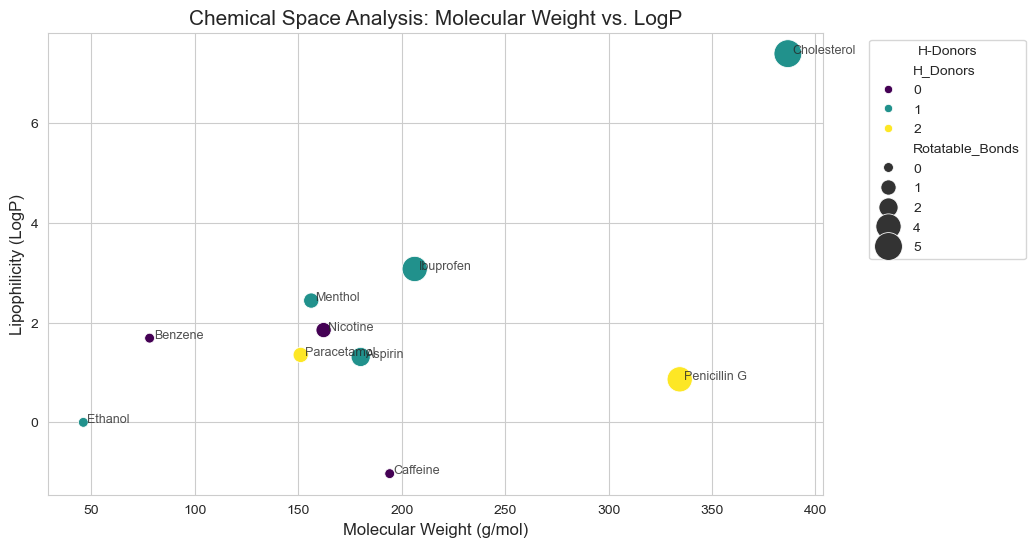

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# التأكد أن الأعمدة أرقام وليست نصوص
df_final['MW'] = df_final['MW'].astype(float)
df_final['LogP'] = df_final['LogP'].astype(float)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# رسم النقاط
scatter = sns.scatterplot(
    data=df_final, 
    x="MW", 
    y="LogP", 
    size="Rotatable_Bonds", 
    hue="H_Donors", 
    palette="viridis",
    sizes=(50, 400)
)

# إضافة أسماء المركبات بطريقة برمجية صحيحة
for i in range(len(df_final)):
    plt.text(
        df_final.iloc[i]['MW'] + 2, # الوصول للقيمة كرقم وزيادة 2 للمسافة
        df_final.iloc[i]['LogP'], 
        str(df_final.iloc[i]['Name']), # التأكد أن الاسم نص
        fontsize=9, 
        alpha=0.8
    )

plt.title("Chemical Space Analysis: Molecular Weight vs. LogP", fontsize=15)
plt.xlabel("Molecular Weight (g/mol)", fontsize=12)
plt.ylabel("Lipophilicity (LogP)", fontsize=12)
plt.legend(title="H-Donors", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("Chemical_Space_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()

In [6]:
import os
import shutil

# 1. تحديد المسار الحالي (المكان اللي فيه الملفات دلوقتي)
current_dir = os.getcwd()

# 2. تحديد مسار الفولدر الجديد على سطح المكتب
# ملحوظة: الكود بيعرف اسم المستخدم بتاعك أوتوماتيك
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
target_folder = os.path.join(desktop_path, 'projects')

# التأكد أن الفولدر موجود فعلاً
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
    print(f"تم إنشاء الفولدر: {target_folder}")

# 3. قائمة بالملفات اللي عايزين ننقلها
files_to_move = [
    'Chemical_Research.db',       # قاعدة البيانات SQL
    'Chemical_Space_Analysis.png'  # الرسم البياني
]

# 4. عملية النقل
for file_name in files_to_move:
    source = os.path.join(current_dir, file_name)
    destination = os.path.join(target_folder, file_name)
    
    if os.path.exists(source):
        shutil.move(source, destination)
        print(f"✅ تم نقل {file_name} بنجاح إلى فولدر projects")
    else:
        print(f"⚠️ الملف {file_name} غير موجود في المسار الحالي")

print(f"\nشغلك كله دلوقتي جاهز ومنظم هنا: {target_folder}")

✅ تم نقل Chemical_Research.db بنجاح إلى فولدر projects
✅ تم نقل Chemical_Space_Analysis.png بنجاح إلى فولدر projects

شغلك كله دلوقتي جاهز ومنظم هنا: C:\Users\scisa\Desktop\projects


In [ ]:
 !pip install pyodbc

In [ ]:
import pandas as pd
import sqlite3

# الاتصال بالملف اللي لسه عاملينه
conn = sqlite3.connect('Chemical_Research.db')

# كويري بيطلع المركبات اللي وزنها الجزيئي (MW) أكبر من 200
query = "SELECT Name, MW, LogP FROM Compounds_Table WHERE MW > 200"

df_query = pd.read_sql(query, conn)
print("📊 نتيجة الكويري (مركبات MW > 200):")
display(df_query)
conn.close()

📊 نتيجة الكويري (مركبات MW > 200):


,Name,MW,LogP
0,Ibuprofen,206.28,3.0732
1,Benzene,78.11,1.6866
2,Ethanol,46.07,-0.0014
3,Penicillin G,334.4,0.8608
4,Cholesterol,386.7,7.3887


In [ ]:
!pip install plotly

In [ ]:
 !pip install nbformat >= 4.2.0

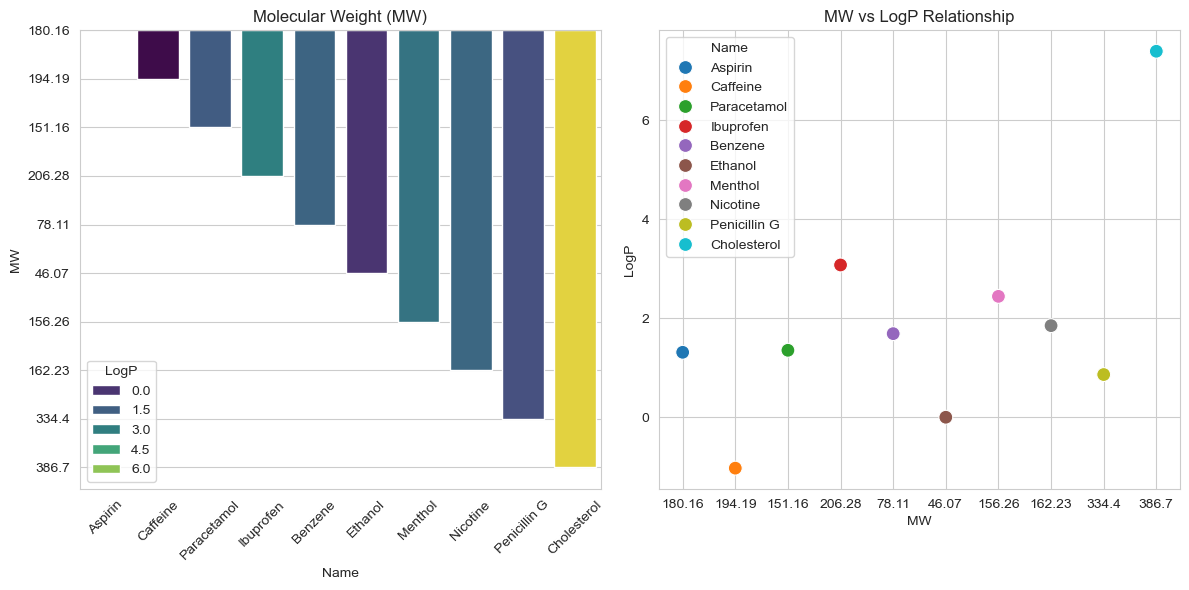

🚀 مبروك يا سارة! الداشبورد ظهر بنجاح كصور ثابتة.


In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# 1. الاتصال بملف الـ SQL وسحب البيانات
conn = sqlite3.connect('Chemical_Research.db')
df_final = pd.read_sql('SELECT * FROM Compounds_Table', conn)
conn.close()

# 2. إنشاء الداشبورد (صور ثابتة ومضمونة)
plt.figure(figsize=(12, 6))

# الرسمة الأولى: الأوزان الجزيئية
plt.subplot(1, 2, 1)
sns.barplot(data=df_final, x='Name', y='MW', hue='LogP', palette='viridis')
plt.title('Molecular Weight (MW)')
plt.xticks(rotation=45)

# الرسمة الثانية: العلاقة بين MW و LogP
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_final, x='MW', y='LogP', hue='Name', s=100)
plt.title('MW vs LogP Relationship')

plt.tight_layout()
plt.show()

print("🚀 مبروك يا سارة! الداشبورد ظهر بنجاح كصور ثابتة.")

In [ ]:
import sqlalchemy

# غيري اسم السيرفر بتاعك هنا
server_name = 'YOUR_SERVER_NAME' 
engine_mssql = sqlalchemy.create_engine(f'mssql+pyodbc://{server_name}/Chemistry_DB?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')

try:
    df_final.to_sql('Compounds_Master', engine_mssql, if_exists='replace', index=False)
    print("✅ الجدول بقى موجود دلوقتي جوه SQL Server في قاعدة بيانات Chemistry_DB.")
except Exception as e:
    print(f"❌ تأكدي من اسم السيرفر ووجود مكتبة pyodbc: {e}")

c:\Users\scisa\miniconda3\envs\chem_new\lib\site-packages\pandas\io\sql.py:1648: SAWarning:

Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.



✅ الجدول بقى موجود دلوقتي جوه SQL Server في قاعدة بيانات Chemistry_DB.


In [12]:
!pip install streamlit

  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   --------------------------------------